# Physics-Informed Neural Networks

Original [paper](https://www.sciencedirect.com/science/article/pii/S0021999118307125) by M.Raissi et al. 

In complex physical, biological or engineering systems, obtaining data is sometimes unachievable. State of the art machine learning techniques cannot provide any guarantee of convergence given the lack of training data. 

**Traditional physics model** creation is a task of a domain expert, who parametrises physics models to best fit a system of interest. For example, creating a model of aircraft dynamics using equations of drag, lift, gravity, thrust, etc., and parametrising the model to attempt to closely match the model to a specific aircraft.

However, sometimes physical systems are hard to parametrise and there does not exist a closed form solution. 

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import value_and_grad, jit, random, vmap
import optax

KEY = random.PRNGKey(1)

## Import Schrodinger Data

In [2]:
data = scipy.io.loadmat("original_paper/Data/NLS.mat")

lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
N0 = 50
N_b = 50
N_f = 20000

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
u = np.real(data['uu'])
v = np.imag(data['uu'])
h = np.sqrt(u**2 + v**2)

# Initial Condition Data
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
t0 = np.zeros(x0.shape)
u0 = u[idx_x,0:1]
v0 = v[idx_x,0:1]

# Boundary Condition Data
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]
t_ub = t_lb = tb
x_ub = np.zeros(tb.shape) + ub[0]
x_lb = np.zeros(tb.shape) + lb[0]

### Visualizing our testing data

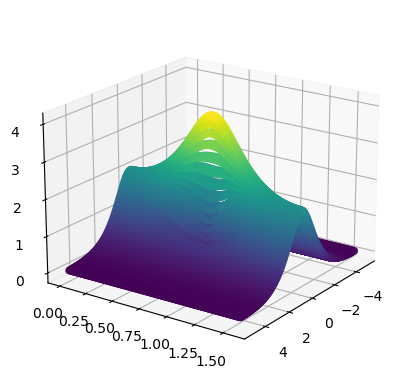

In [3]:
T, X = np.meshgrid(t,x)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 35)
ax.scatter(X, T, h, c=h, cmap='viridis');

### Visualizing our training data on initial condition (t=0)

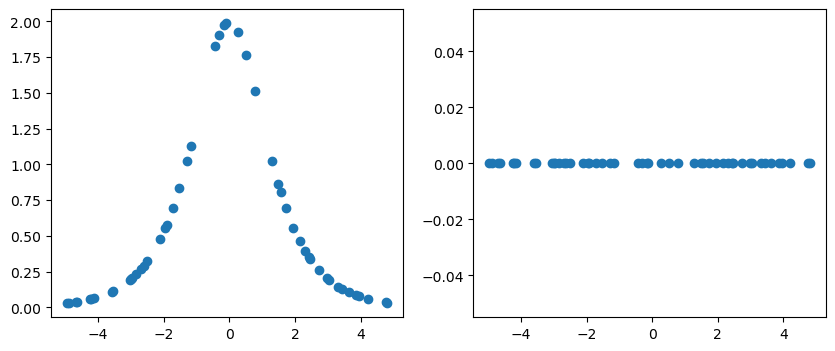

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(x0, u0)
axs[1].scatter(x0, v0)

## Vanilla MLP

First implement `init_params` and `forward`

In [5]:
def init_params(layers, key=KEY):
    '''
    Initialize parameters in the MLP. Weights are initialized
    using Xavier initialization, while biases are zero initialized.

    Returns
    - params: the initialized parameters
    '''
    def xavier_init(input_dim, output_dim, key=key):
        '''Use Xavier initialization for weights of a single layer'''
        std_dev = jnp.sqrt(2/(input_dim + output_dim)) # compute standard deviation for xavier init
        w = std_dev * random.normal(key, (input_dim, output_dim)) # initialize the weights
        return w

    params = []

    for l in range(len(layers) - 1):
        w = xavier_init(layers[l], layers[l+1]) # xavier initialize the weight
        b = jnp.zeros(layers[l+1]) # zero initialize the bias
        params.append((w, b)) # append weight and bias for this layer to params
    
    return params


def forward(params, x):
    '''
    Forward pass through the MLP. In PINN, the nonlinearity are
    applied using tanh.

    Arguments
    - params: weights and biases for all layers of MLP
    - x: input to the MLP

    Returns
    - out: output of the MLP
    '''
    activations = x
    for w, b in params[:-1]:
        out = jnp.dot(activations, w) + b # Perform linear operation
        activations = jnp.tanh(out) # apply tanh activation
    
    final_w, final_b = params[-1]
    out = jnp.dot(activations, final_w) + final_b # Do not apply nonlinearity to last layer
    return out

batched_forward = vmap(forward, in_axes=(None, 0))

Test implementation for `init_param` and `forward`.

In [6]:
layers = [2, 10, 1]
x = random.uniform(KEY, (5, 2))
out = batched_forward(init_params(layers), x)
expected = jnp.array([[-0.05742961],
                     [-0.08960884],
                     [-0.04750253],
                     [-0.17843515],
                     [-0.09102767]])
assert jnp.allclose(out, expected)

Now implement `mseloss` and `update`

In [7]:
def mseloss(params, x, true):
    pred = batched_forward(params, x)
    return jnp.mean(jnp.square(pred - true))

def fit(params, optimizer, X, Y):
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state, x, y):
        loss_value, grads = value_and_grad(mseloss)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i, (x, y) in enumerate(zip(X, Y)):
        params, opt_state, loss_value = step(params, opt_state, x, y)
        print(f'step {i}, loss: {loss_value}')

    return params

In [10]:
layers = [1, 100, 100, 1]
X = x0
Y = u0

optimizer = optax.adam(learning_rate=1e-2)
trained_params = fit(init_params(layers), optimizer, X, Y)

step 0, loss: 0.240827739238739
step 1, loss: 9.32807445526123
step 2, loss: 0.12380366772413254
step 3, loss: 0.0698743686079979
step 4, loss: 3.592803955078125
step 5, loss: 18.42729949951172
step 6, loss: 7.865662097930908
step 7, loss: 5.153502941131592
step 8, loss: 3.013017416000366
step 9, loss: 0.48401182889938354
step 10, loss: 0.6951512098312378
step 11, loss: 1.0768800973892212
step 12, loss: 0.46081700921058655
step 13, loss: 2.3269686698913574
step 14, loss: 1.9480695724487305
step 15, loss: 0.4252415895462036
step 16, loss: 1.2688994407653809
step 17, loss: 0.17695116996765137
step 18, loss: 0.013096085749566555
step 19, loss: 0.1491679698228836
step 20, loss: 0.05356277525424957
step 21, loss: 0.000365149462595582
step 22, loss: 0.2007090002298355
step 23, loss: 1.6417427062988281
step 24, loss: 0.24755050241947174
step 25, loss: 1.5646297931671143
step 26, loss: 1.2110971212387085
step 27, loss: 1.031272053718567
step 28, loss: 0.020396219566464424
step 29, loss: 0.2482

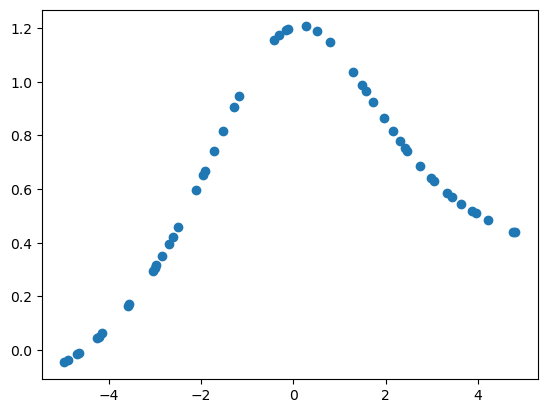

In [13]:
pred = batched_forward(trained_params, X)

plt.scatter(X, pred)